# ORIGEN demo notebook — 2D toy data assimilation with partial observations

This notebook is a minimal, transparent **toy example for data assimilation (DA)** and **3D-Var**.

We define a simple 2D “truth” trajectory on a circle
$$
x_t = (x_1(t), x_2(t)),
$$
and generate **scalar observations** that measure **either** $x_1$ **or** $x_2$ at each time step (with noise).  
All plots are saved into the folder `origen/`.

---

## Cell 1 — Truth trajectory (circle)
We generate the true trajectory $x_t$ with `nn` points on a circle.

Output:
- `xt` of shape `(nn,2)`
- `origen/origen01.png`

---

## Cell 2 — Observation operator: observe $x_1$ or $x_2$
We define a selector:
- `obs_selector[k]=1` $\Rightarrow$ observe $x_1$
- `obs_selector[k]=2` $\Rightarrow$ observe $x_2$

This corresponds to a time-dependent observation operator
$$
y_k = H_k x_k,
\quad H_k \in \{[1,0],[0,1]\},
$$
plus noise.

Output:
- `y`, `obs_selector`
- `origen/origen02.png`

---

## Cell 3 — 3D-Var cycle (persistence model)
We run a full 3D-Var update per time step using persistence as forecast model:
$$
x_{k+1}^b = x_k^a.
$$

3D-Var/Kalman-style update:
$$
x_k^a = x_k^b + K_k\,(y_k - H_k x_k^b),
$$
with
$$
K_k = B H_k^T (H_k B H_k^T + R)^{-1}.
$$

Output:
- `xb`, `xa`, `innovations`
- `origen/origen03.png`

---

## Cell 4 — 2D plot: truth vs analyses
We compare the 2D analysis points $(x_1^a,x_2^a)$ to the truth circle, colored by time step.

Output:
- `origen/origen04.png`

---

## Cell 5 — Two rounds (sequential assimilation)
We demonstrate sequential assimilation:
1. Round 1 assimilates only $x_1$ $\Rightarrow$ `xa1`
2. Round 2 assimilates only $x_2$, with backgrounds set per step as
$$
x_{b,2}(k) := x_{a,1}(k).
$$

Output:
- `origen/origen05.png`, `origen/origen06.png`

---

## Cell 6 — Many cycles with random obs patterns
We repeat assimilation for many cycles. In each cycle we draw a new random pattern of observing $x_1$ vs $x_2$, generate new noisy observations, and set:
$$
x_b^{(cyc+1)} := x_a^{(cyc)}.
$$

Output:
- trajectories, RMSE curve, final-cycle time series
- `origen/origen07.png`, `origen/origen08.png`, `origen/origen09.png`

---

## Cell 7 — Many cycles + covariance update
We additionally update the covariance (uncertainty reduction):
$$
A = (I - K H) B,
\quad B \leftarrow A.
$$

This makes the gain adapt over cycles and typically stabilizes/improves the results.  
Only a subset of cycles is plotted to keep visuals clean.

Output:
- subset trajectories + RMSE + final time series
- `origen/origen10.png`, `origen/origen11.png`, `origen/origen12.png`


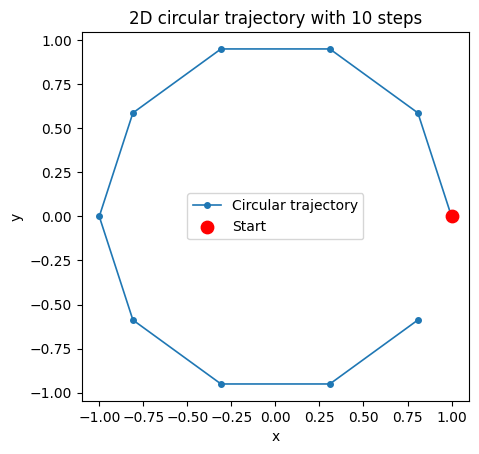

xt shape: (10, 2)
First point: [1. 0.]
Last point: [ 0.80901699 -0.58778525]
Saved figure: origen/origen01.png


In [1]:
# ==============================================================
# Cell: 2D circular trajectory with nn steps (ORIGEN demo)

import os
import numpy as np
import matplotlib.pyplot as plt

# --- Output folder (ORIGEN) ---
out_dir = "origen"
os.makedirs(out_dir, exist_ok=True)

# --- Parameters ---
nn = 10                        # number of steps
r = 1.0                        # radius
center = np.array([0.0, 0.0])  # center point
theta = np.linspace(0, 2*np.pi, nn, endpoint=False)  # angles

# --- Compute points on the circle ---
xt = np.zeros((nn, 2))
xt[:, 0] = center[0] + r * np.cos(theta)
xt[:, 1] = center[1] + r * np.sin(theta)

# --- Visualization ---
fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(xt[:, 0], xt[:, 1], 'o-', ms=4, lw=1.2, label="Circular trajectory")
ax.scatter(xt[0, 0], xt[0, 1], color='red', s=80, zorder=5, label='Start')
ax.set_aspect('equal', adjustable='box')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title(f'2D circular trajectory with {nn} steps')
ax.legend()

out_png = os.path.join(out_dir, "origen01.png")
plt.savefig(out_png, dpi=150, bbox_inches="tight")
plt.show()

# --- Sanity check output ---
print("xt shape:", xt.shape)
print("First point:", xt[0])
print("Last point:", xt[-1])
print("Saved figure:", out_png)


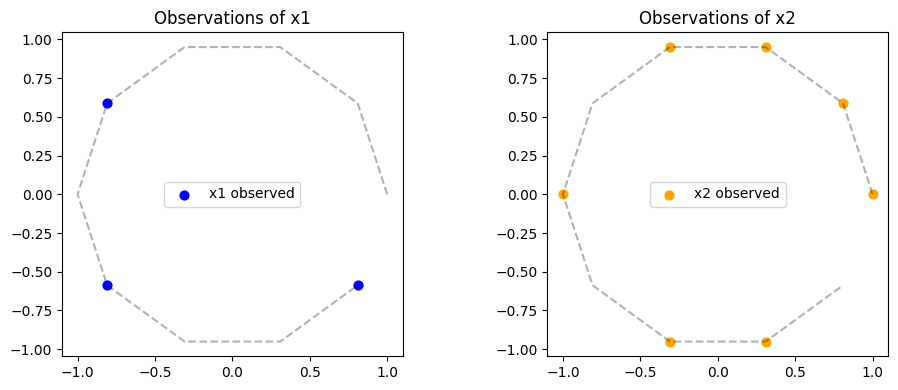

3 observations of x1, 7 observations of x2
Saved figure: origen/origen02.png


In [2]:
# ==============================================================
# Cell: Observation function for x1 or x2 with visualization (ORIGEN demo)

import os
import numpy as np
import matplotlib.pyplot as plt

# --- Output folder (ORIGEN) ---
out_dir = "origen"
os.makedirs(out_dir, exist_ok=True)

def make_observations(xt, obs_selector):
    """
    Create observations of x1 or x2 depending on obs_selector.

    Parameters
    ----------
    xt : ndarray (nn, 2)
        Trajectory points (x1, x2)
    obs_selector : ndarray (nn,)
        Vector with entries 1 or 2:
          1 -> observe x1
          2 -> observe x2

    Returns
    -------
    y : ndarray (nn,)
        Observed values
    """
    nn = len(obs_selector)
    y = np.zeros(nn, dtype=float)
    for i in range(nn):
        if obs_selector[i] == 1:
            y[i] = xt[i, 0]
        elif obs_selector[i] == 2:
            y[i] = xt[i, 1]
        else:
            raise ValueError("obs_selector must contain only 1 or 2.")
    return y

# --- Example: random observations of x1 or x2 ---
np.random.seed(0)
nn = 10
r = 1.0
theta = np.linspace(0, 2*np.pi, nn, endpoint=False)
xt = np.column_stack((r * np.cos(theta), r * np.sin(theta)))

obs_selector = np.random.choice([1, 2], size=nn, p=[0.5, 0.5])
y = make_observations(xt, obs_selector)

# --- Visualization ---
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

# x1 observations
mask1 = (obs_selector == 1)
axs[0].plot(xt[:, 0], xt[:, 1], 'k--', alpha=0.3)
axs[0].scatter(xt[mask1, 0], xt[mask1, 1], c='blue', s=40, label='x1 observed')
axs[0].set_title("Observations of x1")
axs[0].set_aspect('equal', 'box')
axs[0].legend()

# x2 observations
mask2 = (obs_selector == 2)
axs[1].plot(xt[:, 0], xt[:, 1], 'k--', alpha=0.3)
axs[1].scatter(xt[mask2, 0], xt[mask2, 1], c='orange', s=40, label='x2 observed')
axs[1].set_title("Observations of x2")
axs[1].set_aspect('equal', 'box')
axs[1].legend()

plt.tight_layout()
out_png = os.path.join(out_dir, "origen02.png")
plt.savefig(out_png, dpi=150, bbox_inches="tight")
plt.show()

# --- Check ---
print(f"{np.sum(mask1)} observations of x1, {np.sum(mask2)} observations of x2")
print("Saved figure:", out_png)


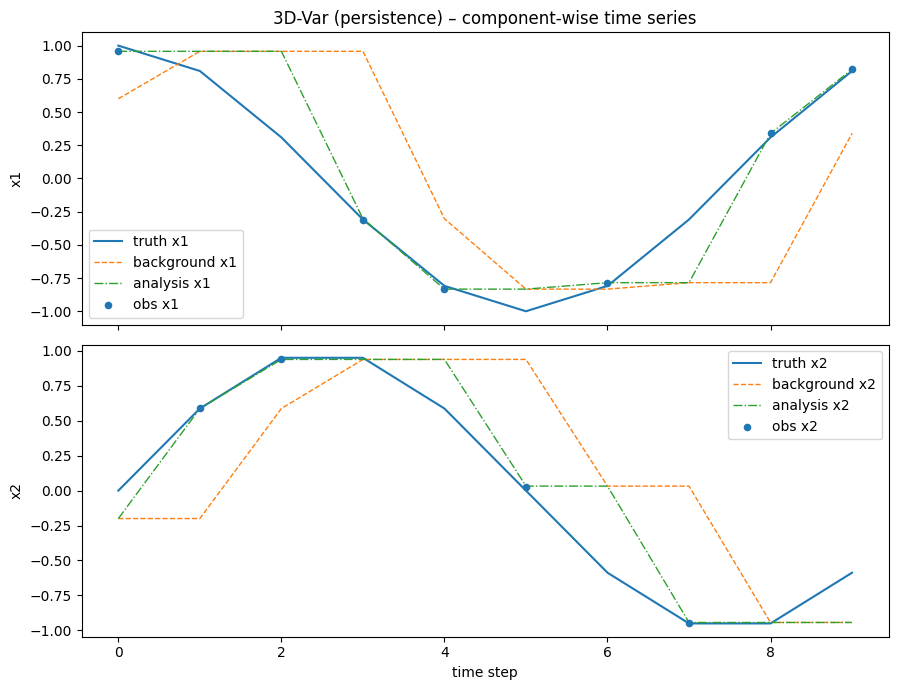

RMSE background: 0.6087 | RMSE analysis: 0.2623
Mean innovation: -5.2531e-02, std: 7.7766e-01
Saved figure: origen/origen03.png


In [3]:
# ==============================================================
# Cell: 3D-Var cycle (persistence model) for 2D state with x1/x2 observations (ORIGEN demo)

import os
import numpy as np
import matplotlib.pyplot as plt

# --- Output folder (ORIGEN) ---
out_dir = "origen"
os.makedirs(out_dir, exist_ok=True)

def three_dvar_cycle(xt, y, obs_selector, x0, B_diag=(0.2, 0.2), R=0.005):
    """
    3D-Var cycle with a persistence model for a 2D state.

    Parameters
    ----------
    xt : (nn, 2) array
        True state at each step (used only for comparison/plots).
    y : (nn,) array
        Observation at each step (scalar).
    obs_selector : (nn,) array of {1, 2}
        1 -> observe x1, 2 -> observe x2 at this step.
    x0 : (2,) array
        Initial background state.
    B_diag : tuple(float, float)
        Diagonal of B (background error variances).
    R : float
        Observation error variance (scalar, constant in time).

    Returns
    -------
    xb, xa : (nn, 2) arrays
        Background and analysis states at each step.
    innovations : (nn,) array
        d_k = y_k - H_k xb_k
    """
    nn = len(y)
    B = np.diag(B_diag)
    xb = np.zeros((nn, 2), dtype=float)
    xa = np.zeros((nn, 2), dtype=float)
    innovations = np.zeros(nn, dtype=float)

    def model_m(x):
        """Persistence model: x_{k+1} = x_k."""
        return x.copy()

    def H_vec(sel):
        """Return H as a 2-vector selecting x1 or x2."""
        if sel == 1:   # observe x1
            return np.array([1.0, 0.0])
        elif sel == 2: # observe x2
            return np.array([0.0, 1.0])
        else:
            raise ValueError("obs_selector must be 1 or 2.")

    xbg = np.array(x0, dtype=float)
    for k in range(nn):
        xb[k] = xbg
        h = H_vec(obs_selector[k])           # (2,)
        HBHt = h @ B @ h                     # scalar
        K = (B @ h) / (HBHt + R)             # (2,)
        d = y[k] - (h @ xbg)                 # innovation
        innovations[k] = d
        xa[k] = xbg + K * d                  # analysis
        xbg = model_m(xa[k])                 # cycle: propagate analysis -> next background

    return xb, xa, innovations

# ---------------- Example usage ----------------
# If xt, y, obs_selector, x0 exist upstream, use them as-is.
# Otherwise, create a minimal demo on a unit circle with noisy observations.

def _ensure_demo_data():
    nn = 10
    theta = np.linspace(0, 2*np.pi, nn, endpoint=False)
    xt = np.column_stack([np.cos(theta), np.sin(theta)])  # true trajectory

    rng = np.random.default_rng(42)
    obs_selector = rng.choice([1, 2], size=nn)

    # Create observations from the selected component with noise N(0, sqrt(R))
    R = 0.001
    noise = rng.normal(0.0, np.sqrt(R), size=nn)
    y = np.where(obs_selector == 1, xt[:, 0], xt[:, 1]) + noise

    x0 = np.array([0.6, -0.2], dtype=float)  # imperfect initial background
    return xt, y, obs_selector, x0, R

# Detect if variables exist; otherwise create demo
_g = globals()
if not all(name in _g for name in ["xt", "y", "obs_selector", "x0"]):
    xt, y, obs_selector, x0, R = _ensure_demo_data()
else:
    # If R is not defined upstream, fall back to the function default
    R = _g.get("R", 0.005)

B_diag = (0.2, 0.2)

# Run the 3D-Var cycle
xb, xa, innovations = three_dvar_cycle(xt, y, obs_selector, x0, B_diag=B_diag, R=R)

# ---------------- Visualization ----------------
nn = len(y)
t = np.arange(nn)
mask1 = (obs_selector == 1)
mask2 = ~mask1

fig, axes = plt.subplots(2, 1, figsize=(9, 7), sharex=True)

# x1 time series
ax = axes[0]
ax.plot(t, xt[:, 0], label="truth x1", lw=1.5)
ax.plot(t, xb[:, 0], linestyle="--", label="background x1", lw=1.0)
ax.plot(t, xa[:, 0], linestyle="-.", label="analysis x1", lw=1.0)
ax.scatter(t[mask1], y[mask1], s=20, label="obs x1", zorder=3)
ax.set_ylabel("x1")
ax.set_title("3D-Var (persistence) – component-wise time series")
ax.legend(loc="best")

# x2 time series
ax = axes[1]
ax.plot(t, xt[:, 1], label="truth x2", lw=1.5)
ax.plot(t, xb[:, 1], linestyle="--", label="background x2", lw=1.0)
ax.plot(t, xa[:, 1], linestyle="-.", label="analysis x2", lw=1.0)
ax.scatter(t[mask2], y[mask2], s=20, label="obs x2", zorder=3)
ax.set_xlabel("time step")
ax.set_ylabel("x2")
ax.legend(loc="best")

plt.tight_layout()
out_png = os.path.join(out_dir, "origen03.png")
plt.savefig(out_png, dpi=150, bbox_inches="tight")
plt.show()

# ---------------- Quick diagnostics ----------------
rmse_b = np.sqrt(np.mean((xb - xt) ** 2))
rmse_a = np.sqrt(np.mean((xa - xt) ** 2))
print(f"RMSE background: {rmse_b:.4f} | RMSE analysis: {rmse_a:.4f}")
print(f"Mean innovation: {innovations.mean():.4e}, std: {innovations.std():.4e}")
print("Saved figure:", out_png)

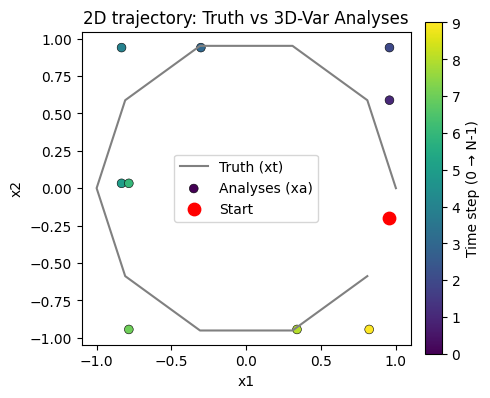

Saved figure: origen/origen04.png


In [4]:
# ==============================================================
# Cell: 2D plot of truth and analyses (3D-Var result) (ORIGEN demo)

import os
import matplotlib.pyplot as plt
import numpy as np

# --- Output folder (ORIGEN) ---
out_dir = "origen"
os.makedirs(out_dir, exist_ok=True)

# --- Ensure xa, xt exist ---
assert "xa" in globals() and "xt" in globals(), "Run the 3D-Var cell first!"

# --- Color gradient by time step ---
nn = len(xa)
cmap = plt.cm.viridis
norm = plt.Normalize(vmin=0, vmax=nn - 1)

fig, ax = plt.subplots(figsize=(5, 5))

# True circle (truth trajectory)
ax.plot(xt[:, 0], xt[:, 1], color="gray", lw=1.5, label="Truth (xt)")

# Analyses with color gradient over time
sc = ax.scatter(
    xa[:, 0], xa[:, 1],
    c=np.arange(nn),
    cmap=cmap,
    s=40,
    edgecolor="k",
    lw=0.4,
    label="Analyses (xa)",
)

# Mark the start point
ax.scatter(xa[0, 0], xa[0, 1], c="red", s=80, zorder=5, label="Start")

# Layout
ax.set_aspect("equal", "box")
ax.set_xlabel("x1")
ax.set_ylabel("x2")
ax.set_title("2D trajectory: Truth vs 3D-Var Analyses")

# Colorbar for time steps
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
cbar = plt.colorbar(sm, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label("Time step (0 → N-1)")

ax.legend(loc="best")
plt.tight_layout()

out_png = os.path.join(out_dir, "origen04.png")
plt.savefig(out_png, dpi=150, bbox_inches="tight")
plt.show()

print("Saved figure:", out_png)

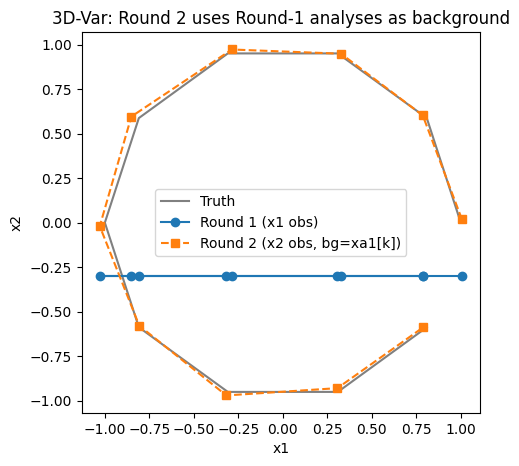

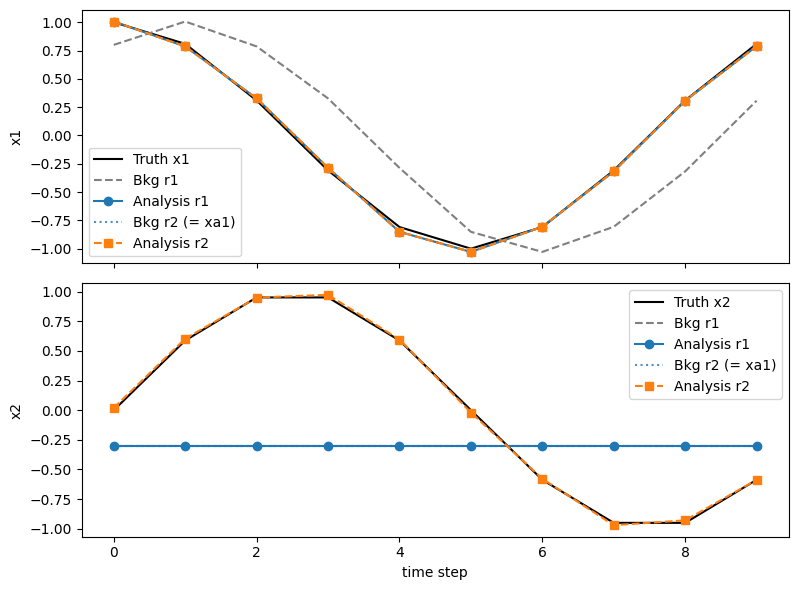

Saved figures:
 - origen/origen05.png
 - origen/origen06.png


In [5]:
# ==============================================================
# Cell: Two rounds with round-2 backgrounds = round-1 analyses (per step) (ORIGEN demo)

import os
import numpy as np
import matplotlib.pyplot as plt

# --- Output folder (ORIGEN) ---
out_dir = "origen"
os.makedirs(out_dir, exist_ok=True)

def three_dvar_cycle_round1(xt, y, obs_selector, x0, B_diag=(0.2, 0.2), R=0.005):
    """
    Round 1: full 3D-Var cycle with a persistence model.
    Returns xb1, xa1.
    """
    nn = len(y)
    B = np.diag(B_diag)
    xb = np.zeros((nn, 2), dtype=float)
    xa = np.zeros((nn, 2), dtype=float)

    def H_vec(sel):
        """Return H as a 2-vector selecting x1 or x2."""
        if sel == 1:
            return np.array([1.0, 0.0])
        elif sel == 2:
            return np.array([0.0, 1.0])
        else:
            raise ValueError("obs_selector must be 1 or 2.")

    xbg = np.array(x0, dtype=float)
    for k in range(nn):
        xb[k] = xbg
        h = H_vec(obs_selector[k])
        HBHt = h @ B @ h
        K = (B @ h) / (HBHt + R)     # (2,)
        d = y[k] - (h @ xbg)
        xa[k] = xbg + K * d
        xbg = xa[k]                  # persistence model
    return xb, xa

def three_dvar_update_per_step(xb_step, y_step, h, B_diag=(0.2, 0.2), R=0.05):
    """
    Single-step 3D-Var analysis given background xb_step and obs y_step with H=h.
    """
    B = np.diag(B_diag)
    HBHt = h @ B @ h
    K = (B @ h) / (HBHt + R)
    return xb_step + K * (y_step - (h @ xb_step))

# ---------------- Setup ----------------
nn = 10
theta = np.linspace(0, 2*np.pi, nn, endpoint=False)
xt = np.column_stack((np.cos(theta), np.sin(theta)))  # truth

R = 0.0005
B_diag = (0.2, 0.2)
rng = np.random.default_rng(42)
x0 = np.array([0.8, -0.3], dtype=float)

# Round 1: observe x1 everywhere
obs_sel1 = np.ones(nn, dtype=int)  # all x1
y1 = xt[:, 0] + rng.normal(0.0, np.sqrt(R), size=nn)
xb1, xa1 = three_dvar_cycle_round1(xt, y1, obs_sel1, x0, B_diag=B_diag, R=R)

# Round 2: observe x2 everywhere, with backgrounds = round-1 analyses at each step
obs_sel2 = np.full(nn, 2, dtype=int)  # all x2
y2 = xt[:, 1] + rng.normal(0.0, np.sqrt(R), size=nn)

xa2 = np.zeros_like(xa1)
xb2 = xa1.copy()  # first guess for round 2 is xa1 at each k
h2 = np.array([0.0, 1.0])
for k in range(nn):
    xa2[k] = three_dvar_update_per_step(xb2[k], y2[k], h2, B_diag=B_diag, R=R)

# ---------------- Visualization ----------------
# 2D plot
fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(xt[:, 0], xt[:, 1], color="gray", lw=1.5, label="Truth")
ax.plot(xa1[:, 0], xa1[:, 1], "o-", label="Round 1 (x1 obs)")
ax.plot(xa2[:, 0], xa2[:, 1], "s--", label="Round 2 (x2 obs, bg=xa1[k])")
ax.set_aspect("equal", "box")
ax.set_xlabel("x1")
ax.set_ylabel("x2")
ax.set_title("3D-Var: Round 2 uses Round-1 analyses as background")
ax.legend()
plt.tight_layout()

out_png_2d = os.path.join(out_dir, "origen05.png")
plt.savefig(out_png_2d, dpi=150, bbox_inches="tight")
plt.show()

# Time series x1 / x2
t = np.arange(nn)
fig, axs = plt.subplots(2, 1, figsize=(8, 6), sharex=True)

# x1
axs[0].plot(t, xt[:, 0], "k-", lw=1.5, label="Truth x1")
axs[0].plot(t, xb1[:, 0], "--", color="gray", label="Bkg r1")
axs[0].plot(t, xa1[:, 0], "o-", label="Analysis r1")
axs[0].plot(t, xb2[:, 0], ":", color="tab:blue", alpha=0.8, label="Bkg r2 (= xa1)")
axs[0].plot(t, xa2[:, 0], "s--", label="Analysis r2")
axs[0].set_ylabel("x1")
axs[0].legend()

# x2
axs[1].plot(t, xt[:, 1], "k-", lw=1.5, label="Truth x2")
axs[1].plot(t, xb1[:, 1], "--", color="gray", label="Bkg r1")
axs[1].plot(t, xa1[:, 1], "o-", label="Analysis r1")
axs[1].plot(t, xb2[:, 1], ":", color="tab:blue", alpha=0.8, label="Bkg r2 (= xa1)")
axs[1].plot(t, xa2[:, 1], "s--", label="Analysis r2")
axs[1].set_xlabel("time step")
axs[1].set_ylabel("x2")
axs[1].legend()

plt.tight_layout()

out_png_ts = os.path.join(out_dir, "origen06.png")
plt.savefig(out_png_ts, dpi=150, bbox_inches="tight")
plt.show()

# --- Output ---
print("Saved figures:")
print(" -", out_png_2d)
print(" -", out_png_ts)

Cycle 1: RMSE = 0.7738
Cycle 2: RMSE = 0.5641
Cycle 3: RMSE = 0.3705
Cycle 4: RMSE = 0.2879
Cycle 5: RMSE = 0.2542
Cycle 6: RMSE = 0.2544
Cycle 7: RMSE = 0.2680
Cycle 8: RMSE = 0.2271
Cycle 9: RMSE = 0.2049
Cycle 10: RMSE = 0.2192
Cycle 11: RMSE = 0.1821
Cycle 12: RMSE = 0.1720
Cycle 13: RMSE = 0.1733
Cycle 14: RMSE = 0.1779
Cycle 15: RMSE = 0.2016
Cycle 16: RMSE = 0.1834
Cycle 17: RMSE = 0.2036
Cycle 18: RMSE = 0.1825
Cycle 19: RMSE = 0.1720
Cycle 20: RMSE = 0.1679
Cycle 21: RMSE = 0.2035
Cycle 22: RMSE = 0.1635
Cycle 23: RMSE = 0.1828
Cycle 24: RMSE = 0.1874
Cycle 25: RMSE = 0.1688
Cycle 26: RMSE = 0.1774
Cycle 27: RMSE = 0.1738
Cycle 28: RMSE = 0.1872
Cycle 29: RMSE = 0.1597
Cycle 30: RMSE = 0.1677
Cycle 31: RMSE = 0.1708
Cycle 32: RMSE = 0.2048
Cycle 33: RMSE = 0.2095
Cycle 34: RMSE = 0.1748
Cycle 35: RMSE = 0.1924
Cycle 36: RMSE = 0.1883
Cycle 37: RMSE = 0.1856
Cycle 38: RMSE = 0.1873
Cycle 39: RMSE = 0.1810
Cycle 40: RMSE = 0.1934
Cycle 41: RMSE = 0.1620
Cycle 42: RMSE = 0.1938
C

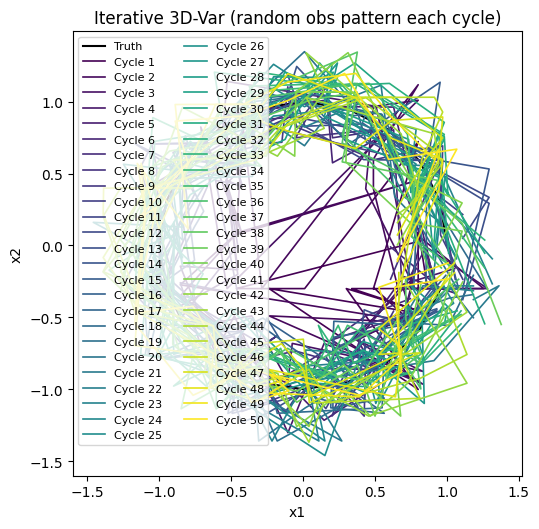

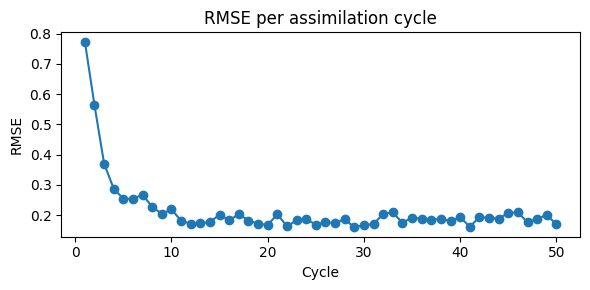

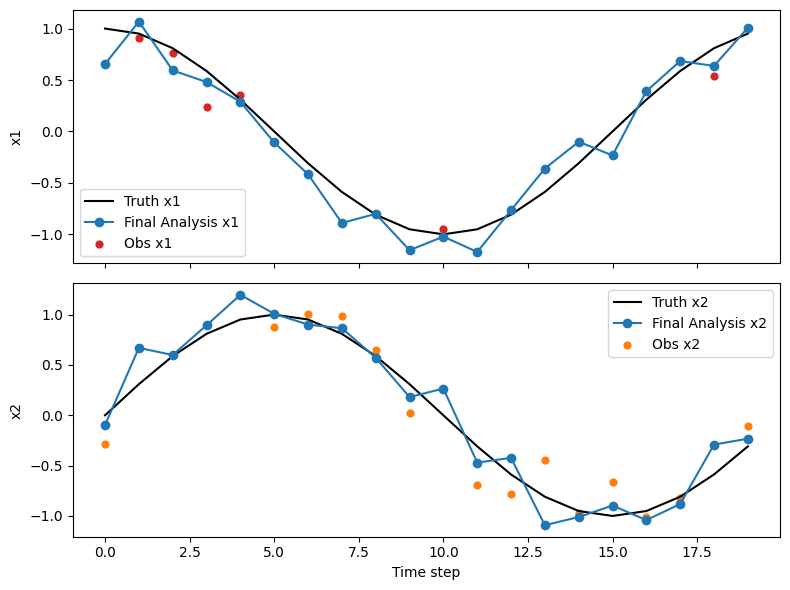

Saved figures:
 - origen/origen07.png
 - origen/origen08.png
 - origen/origen09.png


In [6]:
# ==============================================================
# Cell: Iterative 3D-Var with new random x1/x2 observations each cycle (ORIGEN demo)

import os
import numpy as np
import matplotlib.pyplot as plt

# --- Output folder (ORIGEN) ---
out_dir = "origen"
os.makedirs(out_dir, exist_ok=True)

# --- Parameters ---
nn = 20              # number of time steps
n_cycles = 50        # number of 3D-Var iterations (cycles)
R = 0.05             # observation error variance
B_diag = (0.2, 0.2)  # diagonal background covariance (variances)
rng = np.random.default_rng(2)

# --- Truth: 2D oscillator (circle) ---
theta = np.linspace(0, 2 * np.pi, nn, endpoint=False)
xt = np.column_stack((np.cos(theta), np.sin(theta)))

# --- Helper functions ---
def H_vec(sel):
    """Return H as a 2-vector selecting x1 or x2."""
    if sel == 1:
        return np.array([1.0, 0.0])
    elif sel == 2:
        return np.array([0.0, 1.0])
    else:
        raise ValueError("Selector must be 1 or 2.")

def analysis_step(xb, y, sel, B_diag, R):
    """Single-step 3D-Var analysis for a 2D state with one scalar observation."""
    B = np.diag(B_diag)
    h = H_vec(sel)
    HBHt = h @ B @ h
    K = (B @ h) / (HBHt + R)
    return xb + K * (y - (h @ xb))

# --- Initialization ---
x0 = np.array([0.8, -0.3], dtype=float)
xb_seq = np.tile(x0, (nn, 1))  # same initial background for all steps
rmse_hist = []
all_xa = []

# --- Iterative cycles ---
# Note: Each cycle uses a NEW random observation pattern (x1 vs x2) and NEW noise.
# This is not the usual "re-assimilate the same obs until convergence" setting,
# but a didactic example showing repeated random partial observation updates.
for cyc in range(n_cycles):
    # New random selection of observed component at each time step
    obs_selector = rng.choice([1, 2], size=nn)

    # Generate the corresponding noisy scalar observations
    y_true = np.where(obs_selector == 1, xt[:, 0], xt[:, 1])
    y = y_true + rng.normal(0.0, np.sqrt(R), size=nn)

    # Perform 3D-Var independently at each step (no model coupling in time)
    xa_seq = np.array(
        [analysis_step(xb_seq[k], y[k], obs_selector[k], B_diag, R) for k in range(nn)],
        dtype=float
    )

    # Store results
    all_xa.append(xa_seq)
    xb_seq = xa_seq.copy()

    rmse = np.sqrt(np.mean((xa_seq - xt) ** 2))
    rmse_hist.append(rmse)
    print(f"Cycle {cyc + 1}: RMSE = {rmse:.4f}")

# ==============================================================
# Visualization
# --------------------------------------------------------------

# 2D trajectories for all cycles (can get visually busy for many cycles)
colors = plt.cm.viridis(np.linspace(0, 1, n_cycles))
fig, ax = plt.subplots(figsize=(5.5, 5.5))
ax.plot(xt[:, 0], xt[:, 1], "k-", lw=1.5, label="Truth")

for i, xa_i in enumerate(all_xa):
    ax.plot(xa_i[:, 0], xa_i[:, 1], color=colors[i], lw=1.2, label=f"Cycle {i + 1}")

ax.set_aspect("equal", "box")
ax.set_xlabel("x1")
ax.set_ylabel("x2")
ax.set_title("Iterative 3D-Var (random obs pattern each cycle)")
ax.legend(fontsize=8, ncol=2)
plt.tight_layout()

out_png_traj = os.path.join(out_dir, "origen07.png")
plt.savefig(out_png_traj, dpi=150, bbox_inches="tight")
plt.show()

# RMSE progression
plt.figure(figsize=(6, 3))
plt.plot(np.arange(1, n_cycles + 1), rmse_hist, "o-")
plt.xlabel("Cycle")
plt.ylabel("RMSE")
plt.title("RMSE per assimilation cycle")
plt.tight_layout()

out_png_rmse = os.path.join(out_dir, "origen08.png")
plt.savefig(out_png_rmse, dpi=150, bbox_inches="tight")
plt.show()

# Final cycle: time series view + observations used for plotting
t = np.arange(nn)
xa_last = all_xa[-1]

# Important: obs_selector from the LOOP is the last cycle's selector here.
obs_selector_last = obs_selector.copy()
y_last_true = np.where(obs_selector_last == 1, xt[:, 0], xt[:, 1])
y_last = y_last_true + rng.normal(0.0, np.sqrt(R), size=nn)

fig, axs = plt.subplots(2, 1, figsize=(8, 6), sharex=True)

axs[0].plot(t, xt[:, 0], "k-", lw=1.5, label="Truth x1")
axs[0].plot(t, xa_last[:, 0], "o-", label="Final Analysis x1")
axs[0].scatter(
    t[obs_selector_last == 1],
    y_last[obs_selector_last == 1],
    s=24,
    color="tab:red",
    label="Obs x1",
)
axs[0].set_ylabel("x1")
axs[0].legend()

axs[1].plot(t, xt[:, 1], "k-", lw=1.5, label="Truth x2")
axs[1].plot(t, xa_last[:, 1], "o-", label="Final Analysis x2")
axs[1].scatter(
    t[obs_selector_last == 2],
    y_last[obs_selector_last == 2],
    s=24,
    color="tab:orange",
    label="Obs x2",
)
axs[1].set_xlabel("Time step")
axs[1].set_ylabel("x2")
axs[1].legend()

plt.tight_layout()

out_png_ts = os.path.join(out_dir, "origen09.png")
plt.savefig(out_png_ts, dpi=150, bbox_inches="tight")
plt.show()

# --- Output ---
print("Saved figures:")
print(" -", out_png_traj)
print(" -", out_png_rmse)
print(" -", out_png_ts)


Cycle    1/1000: RMSE = 0.58288
Cycle  101/1000: RMSE = 0.02979
Cycle  201/1000: RMSE = 0.01839
Cycle  301/1000: RMSE = 0.01572
Cycle  401/1000: RMSE = 0.01494
Cycle  501/1000: RMSE = 0.01307
Cycle  601/1000: RMSE = 0.01103
Cycle  701/1000: RMSE = 0.01118
Cycle  801/1000: RMSE = 0.01052
Cycle  901/1000: RMSE = 0.00900
Cycle 1000/1000: RMSE = 0.00831


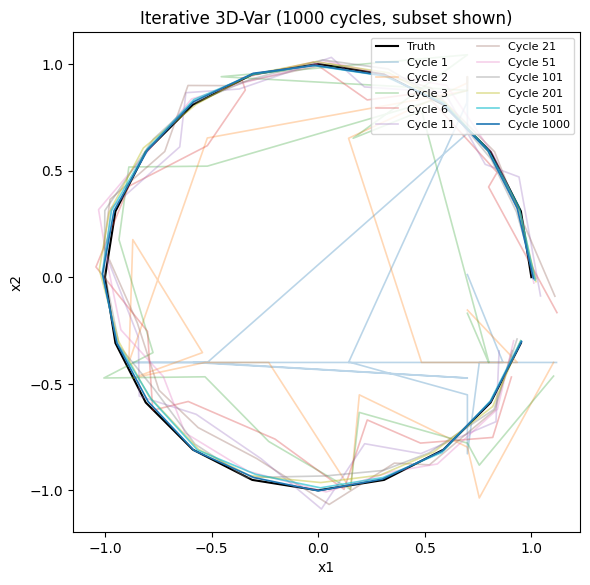

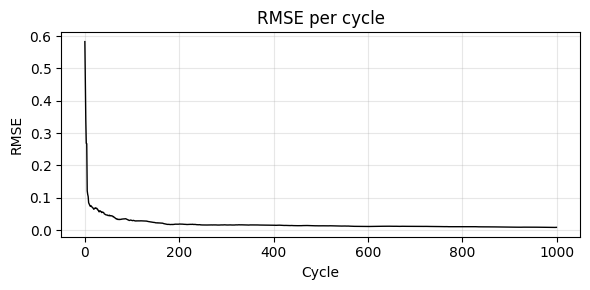

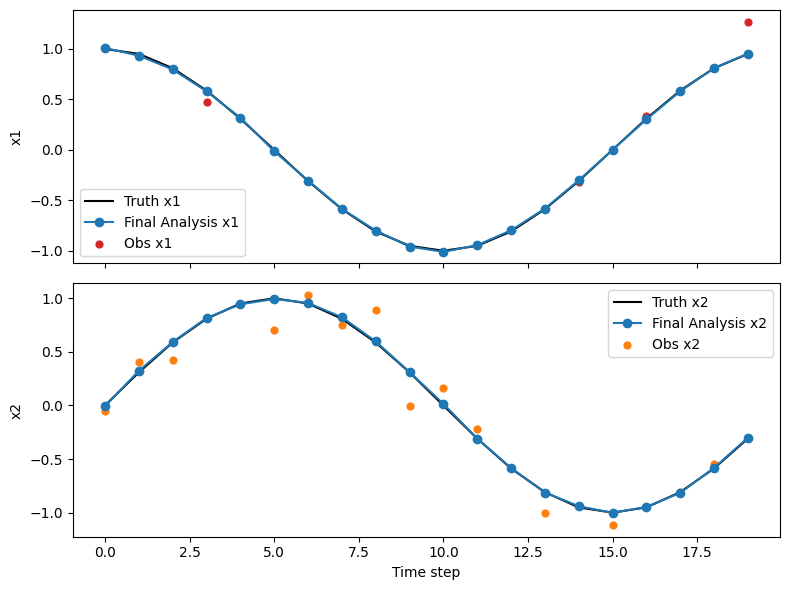

Saved figures:
 - origen/origen10.png
 - origen/origen11.png
 - origen/origen12.png


In [7]:
# ==============================================================
# Cell: Iterative 3D-Var with covariance update and clean visuals for many cycles (ORIGEN demo)

import os
import numpy as np
import matplotlib.pyplot as plt

# --- Output folder (ORIGEN) ---
out_dir = "origen"
os.makedirs(out_dir, exist_ok=True)

# ---------------- Parameters ----------------
nn = 20            # time steps
n_cycles = 1000    # assimilation cycles
R = 0.04           # observation error variance
B0_diag = (0.5, 0.5)
rng = np.random.default_rng(3)

# ---------------- Truth: 2D oscillator (circle) ----------------
theta = np.linspace(0, 2 * np.pi, nn, endpoint=False)
xt = np.column_stack((np.cos(theta), np.sin(theta)))

# ---------------- Helper functions ----------------
def H_vec(sel):
    """Return H as a 2-vector selecting x1 or x2."""
    if sel == 1:
        return np.array([1.0, 0.0])
    elif sel == 2:
        return np.array([0.0, 1.0])
    else:
        raise ValueError("Selector must be 1 or 2.")

# ---------------- Initial background ----------------
x0 = np.array([0.7, -0.4], dtype=float)
xb_seq = np.tile(x0, (nn, 1))  # same initial background for each time step

# Per-step covariance matrices (2x2). Start with diagonal B0.
B_seq = np.array([np.diag(B0_diag).astype(float) for _ in range(nn)])

rmse_hist = []
all_xa = []  # store only a subset of cycles for plotting
last_obs_selector = None
last_y = None

# ---------------- Assimilation cycles ----------------
for cyc in range(n_cycles):
    # New random selection of observed component and new noise each cycle
    obs_selector = rng.choice([1, 2], size=nn)
    y_true = np.where(obs_selector == 1, xt[:, 0], xt[:, 1])
    y = y_true + rng.normal(0.0, np.sqrt(R), size=nn)

    xa_seq = np.zeros_like(xb_seq, dtype=float)
    A_seq = np.zeros_like(B_seq, dtype=float)

    for k in range(nn):
        B = B_seq[k]
        h = H_vec(obs_selector[k])
        HBHt = h @ B @ h
        K = (B @ h) / (HBHt + R)
        d = y[k] - (h @ xb_seq[k])

        # Analysis update
        xa_seq[k] = xb_seq[k] + K * d

        # Covariance update (analysis covariance)
        # A = (I - K h^T) B ; with scalar obs h is (2,), so K is (2,)
        A_seq[k] = B - np.outer(K, h) @ B

    # Cycle forward: analysis becomes next background, and A becomes next B
    xb_seq = xa_seq.copy()
    B_seq = A_seq.copy()

    rmse = np.sqrt(np.mean((xa_seq - xt) ** 2))
    rmse_hist.append(rmse)

    # Store a few cycles only (for clean plots)
    keep = {0, 1, 2, 5, 10, 20, 50, 100, 200, 500, n_cycles - 1}
    if cyc in keep:
        all_xa.append((cyc + 1, xa_seq.copy()))

    # Store final-cycle observation pattern and obs for the time-series plot
    if cyc == n_cycles - 1:
        last_obs_selector = obs_selector.copy()
        last_y = y.copy()

    # Periodic progress output
    if cyc % max(1, n_cycles // 10) == 0 or cyc == n_cycles - 1:
        print(f"Cycle {cyc + 1:4d}/{n_cycles}: RMSE = {rmse:.5f}")

# ---------------- Visualization ----------------

# 2D: Truth + selected analysis trajectories
fig, ax = plt.subplots(figsize=(6, 6))
ax.plot(xt[:, 0], xt[:, 1], "k-", lw=1.5, label="Truth")

for cyc_num, xa_i in all_xa:
    alpha = 0.3 + 0.7 * (cyc_num / n_cycles)  # later cycles more opaque
    ax.plot(xa_i[:, 0], xa_i[:, 1], lw=1.2, alpha=alpha, label=f"Cycle {cyc_num}")

ax.set_aspect("equal", "box")
ax.set_xlabel("x1")
ax.set_ylabel("x2")
ax.set_title(f"Iterative 3D-Var ({n_cycles} cycles, subset shown)")
ax.legend(fontsize=8, ncol=2, loc="upper right")
plt.tight_layout()

out_png_traj = os.path.join(out_dir, "origen10.png")
plt.savefig(out_png_traj, dpi=150, bbox_inches="tight")
plt.show()

# RMSE plot
plt.figure(figsize=(6, 3))
plt.plot(rmse_hist, "k-", lw=1.0)
plt.xlabel("Cycle")
plt.ylabel("RMSE")
plt.title("RMSE per cycle")
plt.grid(True, alpha=0.3)
plt.tight_layout()

out_png_rmse = os.path.join(out_dir, "origen11.png")
plt.savefig(out_png_rmse, dpi=150, bbox_inches="tight")
plt.show()

# Final cycle: x1/x2 time series with the final cycle's observations
t = np.arange(nn)
xa_last = xa_seq

fig, axs = plt.subplots(2, 1, figsize=(8, 6), sharex=True)

axs[0].plot(t, xt[:, 0], "k-", lw=1.5, label="Truth x1")
axs[0].plot(t, xa_last[:, 0], "o-", label="Final Analysis x1")
axs[0].scatter(
    t[last_obs_selector == 1],
    last_y[last_obs_selector == 1],
    s=24,
    color="tab:red",
    label="Obs x1",
)
axs[0].set_ylabel("x1")
axs[0].legend()

axs[1].plot(t, xt[:, 1], "k-", lw=1.5, label="Truth x2")
axs[1].plot(t, xa_last[:, 1], "o-", label="Final Analysis x2")
axs[1].scatter(
    t[last_obs_selector == 2],
    last_y[last_obs_selector == 2],
    s=24,
    color="tab:orange",
    label="Obs x2",
)
axs[1].set_xlabel("Time step")
axs[1].set_ylabel("x2")
axs[1].legend()

plt.tight_layout()

out_png_ts = os.path.join(out_dir, "origen12.png")
plt.savefig(out_png_ts, dpi=150, bbox_inches="tight")
plt.show()

# --- Output ---
print("Saved figures:")
print(" -", out_png_traj)
print(" -", out_png_rmse)
print(" -", out_png_ts)
